In [31]:
import datetime
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, RFECV
from math import sqrt

%run src/columns.py
%run src/data-cleaning.py
%run src/feature-engineering.py
%run src/modeling.py
%run src/aws-scripts.py

In [32]:
csv_file_names = ('LoanStats3a_securev1.csv', 'LoanStats3b_securev1.csv', 'LoanStats3c_securev1.csv',
                  'LoanStats3d_securev1.csv', 'LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv',
                  'LoanStats_securev1_2016Q3.csv', 'LoanStats_securev1_2016Q4.csv', 'LoanStats_securev1_2017Q1.csv',
                  'LoanStats_securev1_2017Q2.csv', 'LoanStats_securev1_2017Q3.csv', 'LoanStats_securev1_2017Q4.csv',
                  'LoanStats_securev1_2018Q1.csv', 'LoanStats_securev1_2018Q1.csv', 'LoanStats_securev1_2018Q2.csv')

In [33]:
loans = pd.read_pickle('data/raw_dataframe.pkl.bz2')
loans = drop_loan_status(loans)
loans = drop_joint_applicant_loans(loans)
loans = fix_rate_cols(loans)
loans.dropna(subset=['issue_d'], inplace=True)
loans = fix_date_cols(loans)
loans = clean_loan_term_col(loans)
loans = only_include_36_month_loans(loans)
loans = clean_employment_length(loans)
loans = create_missing_data_boolean_columns(loans)
loans = fill_nas(loans, value=-99)
loans = fill_nas(loans, value=-99)
loans = add_issue_date_and_month(loans)
loans = add_supplemental_rate_data(loans)
loans = create_rate_difference_cols(loans)
loans = create_months_since_earliest_cl_col(loans)
loans = create_loan_life_months_col(loans)
loans = change_data_types(loans)
loans = create_dummy_cols(loans)
loans = drop_unnecessary_cols(loans)

(2001317, 130769    Apr-2018
 130770    Apr-2018
 130771    Apr-2018
 130772         NaN
 130773         NaN
 Name: issue_d, dtype: object)

In [61]:
cutoff_date = '2015-09-01'
training_loans, testing_loans = get_training_and_testing_data(loans, cutoff_date)

In [62]:
len(training_loans)

529507

In [65]:
loans.set_index('id', inplace=True)

In [68]:
cutoff_date = '2015-09-01'
training_loans, testing_loans = get_training_and_testing_data(loans, cutoff_date)

In [70]:
len(training_loans)

529507

In [71]:
with open('data/loan_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)
    
len(loan_rois)

529507

In [72]:
roi_col = pd.DataFrame.from_dict(loan_rois, orient='index')
roi_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529507 entries, 1077501 to 36271262
Data columns (total 1 columns):
0    529507 non-null float64
dtypes: float64(1)
memory usage: 8.1 MB


In [73]:
training_loans['roi'] = roi_col
training_loans['roi'].head(10)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


id
1077501    10.289307
1077175    16.248779
1076863    13.707275
1075269     7.783084
1072053    19.114990
1069908    12.606201
1064687   -97.884317
1069866     9.896030
1069057   -30.444461
1069759    16.585693
Name: roi, dtype: float64

In [74]:
len(training_loans['roi'].isnull())

529507

In [75]:
training_loans['roi'].tail()

id
36221446    17.425537
36330911   -72.777158
36371250    12.703857
36441262    12.677002
36271262    12.943115
Name: roi, dtype: float64

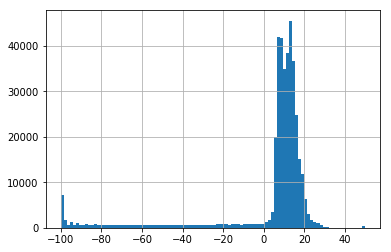

In [77]:
training_loans['roi'].hist(bins=100)

In [78]:
training_loans.to_pickle('data/cleaned_training_loans.pkl.bz2', compression='bz2')
testing_loans.to_pickle('data/cleaned_testing_loans.pkl.bz2', compression='bz2')

In [79]:
loans[['issue_d', 'int_rate']].groupby(['issue_d'], as_index=False).agg(['mean'])

,int_rate
,mean
issue_d,
2007-06-01,13.750000
2007-07-01,9.254666
2007-08-01,10.294848
2007-09-01,10.083889
2007-10-01,10.806808
2007-11-01,9.798649
2007-12-01,10.659177
2008-01-01,10.545381
